# 聚类分析

# 案例分析——广告效果聚类分析（KMeans）

In [22]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction import DictVectorizer  # 字符串分类转整数分类库
from sklearn.preprocessing import MinMaxScaler # MinMaxScaler库
from sklearn.cluster import KMeans   # KMeans 模块
from sklearn import metrics   # 效果评估模块
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook',font='simhei',style='whitegrid') 
%matplotlib inline

## 1.数据读取

In [1]:
data = pd.read_csv('ad_performance.txt',delimiter='\t')
data.head(3)

,渠道代号,日均UV,平均注册率,平均搜索量,访问深度,平均停留时间,订单转化率,投放总时间,素材类型,广告类型,合作方式,广告尺寸,广告卖点
0,A203,3.69,0.0071,0.0214,2.3071,419.77,0.0258,20.0,jpg,banner,roi,140*40,打折
1,A387,178.70,0.0040,0.0324,2.0489,157.94,0.0030,19.0,jpg,banner,cpc,140*40,满减
2,A388,91.77,0.0022,0.0530,1.8771,357.93,0.0026,4.0,jpg,banner,cpc,140*40,满减


渠道代号：业务方统一命名规划的唯一渠道标志  
日均uv：每天的平均独立访客，从一个渠道中带来的一个访客，即使一天中到达多次都统计为1次。  
平均注册率：日均注册的用户数/平均每天的访问量   
平均搜索量：平均每个访问的搜索次数  
访问深度：总页面浏览量/平均每天的访问量  
平均停留时间：总停留时间/平均每天的访问量  
订单转化率：总订单数量/平均每天的访问量  
投放总时间：每个广告媒介在站外投放的天数  
素材类型：广告素材包括jpg,gif,swf,sp  
广告类型：广告投放类型，包括banner, tips、横幅、通栏、暂停以及不确定（不知道是何种形式）  
合作方式：包括roi, cpc, cpm和cpd  
广告尺寸：每个广告投放的尺寸大小，包括140x40、308x388、450x300、600x90、480x360、960x126、900x120、390x270  
广告卖点：广告素材主要的卖点诉求信息，包括打折、满减、满赠、秒杀、直降、满返  

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   渠道代号    889 non-null    object 
 1   日均UV    889 non-null    float64
 2   平均注册率   889 non-null    float64
 3   平均搜索量   889 non-null    float64
 4   访问深度    889 non-null    float64
 5   平均停留时间  887 non-null    float64
 6   订单转化率   889 non-null    float64
 7   投放总时间   889 non-null    float64
 8   素材类型    889 non-null    object 
 9   广告类型    889 non-null    object 
 10  合作方式    889 non-null    object 
 11  广告尺寸    889 non-null    object 
 12  广告卖点    889 non-null    object 
dtypes: float64(7), object(6)
memory usage: 90.4+ KB


In [3]:
# 这样用表格形式展示每个字段有多少缺失值
pd.DataFrame(data.isnull().sum(),columns=["num"]).T

,渠道代号,日均UV,平均注册率,平均搜索量,访问深度,平均停留时间,订单转化率,投放总时间,素材类型,广告类型,合作方式,广告尺寸,广告卖点
num,0,0,0,0,0,2,0,0,0,0,0,0,0


In [4]:
# 缺失值用字段均值代替
data_2  = data.fillna(data["平均停留时间"].mean())

# 描述性统计
data_2.describe().round(3)

,日均UV,平均注册率,平均搜索量,访问深度,平均停留时间,订单转化率,投放总时间
count,889.000,889.000,889.000,889.000,889.000,889.000,889.000
mean,540.847,0.001,0.030,2.167,262.669,0.003,16.053
std,1634.410,0.003,0.106,3.801,224.112,0.012,8.509
min,0.060,0.000,0.000,1.000,1.640,0.000,1.000
25%,6.180,0.000,0.001,1.392,126.200,0.000,9.000
50%,114.180,0.000,0.003,1.793,236.660,0.000,16.000
75%,466.870,0.001,0.012,2.216,357.930,0.002,24.000
max,25294.770,0.039,1.037,98.980,4450.830,0.216,30.000


In [5]:
data_2.corr().round(2)

,日均UV,平均注册率,平均搜索量,访问深度,平均停留时间,订单转化率,投放总时间
日均UV,1.00,-0.05,-0.07,-0.02,0.04,-0.05,-0.04
平均注册率,-0.05,1.00,0.24,0.11,0.22,0.32,-0.01
平均搜索量,-0.07,0.24,1.00,0.06,0.17,0.13,-0.03
访问深度,-0.02,0.11,0.06,1.00,0.72,0.16,0.06
平均停留时间,0.04,0.22,0.17,0.72,1.00,0.25,0.05
订单转化率,-0.05,0.32,0.13,0.16,0.25,1.00,-0.00
投放总时间,-0.04,-0.01,-0.03,0.06,0.05,-0.00,1.00


## 2.数据预处理

In [6]:
# 将字符串转换成整数，离散化
cols = ["素材类型", "广告类型", "合作方式", "广告尺寸", "广告卖点"]

convert_matrix = data_2[cols]
lines = convert_matrix.shape[0]
dict_list = []  # 存放字符串与对应索引组成的字典
unique_list = []  # 总唯一值列表，用于存放每个列的唯一值列表

for col_name in cols:
    col_unique_vlaue = data_2[col_name].unique().tolist()  # 每列唯一值列表
    unique_list.append(col_unique_vlaue)  # 将列表存入总表
    
for line_index in range(lines):
    each_record = convert_matrix.iloc[line_index]   # 读取每行数据,结果是series
    for each_index,each_data in enumerate(each_record):
        # 读取series中每行的值及其对应的index（原列名）的数字索引值。
        list_value = unique_list[each_index]
        # 读取行索引对应的列唯一值
        each_record[each_index] = list_value.index(each_data)
        # 将每一个值对应到唯一值列表中的索引
    each_dict = dict(zip(cols,each_record))
    dict_list.append(each_dict)
    
model_transform = DictVectorizer(separator=False,dtype=np.int64)
data_dicvec = model_transform.fit_transform(dict_list).toarray()
data_dicvec

array([[0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0],
       [1, 1, 0, 0, 0],
       ...,
       [1, 0, 6, 4, 1],
       [3, 0, 6, 4, 1],
       [1, 4, 7, 5, 2]])

从数据可以看到，UV和转化率这些字段的数据处在不同的量级，UV有上万，而转化率却小于1，因此需要做数据标准化，这里采用MINMAX标准化

In [7]:
# 数据标准化
scaler_matrix = data_2.iloc[:,1:8]
minmax_scaler = MinMaxScaler()
data_scaler = minmax_scaler.fit_transform(scaler_matrix)

# 合并数据
data3 = np.hstack((data_scaler,data_dicvec))  # 横向合并
data3

array([[1.43508267e-04, 1.81585678e-01, 2.06364513e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.06234624e-03, 1.02301790e-01, 3.12439730e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.62565928e-03, 5.62659847e-02, 5.11089682e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.22741079e-02, 5.11508951e-03, 2.70009643e-03, ...,
        6.00000000e+00, 4.00000000e+00, 1.00000000e+00],
       [5.41741732e-02, 2.55754476e-03, 1.54291225e-03, ...,
        6.00000000e+00, 4.00000000e+00, 1.00000000e+00],
       [3.16271663e-05, 0.00000000e+00, 0.00000000e+00, ...,
        7.00000000e+00, 5.00000000e+00, 2.00000000e+00]])

## 3.如何选择kmeans中的k值

肘部法则–Elbow Method和轮廓系数–Silhouette Coefficient

In [8]:
k =3
kmodel = KMeans(n_clusters = k,random_state=0) 
kmodel.fit(data3) #训练模型

KMeans(n_clusters=3, random_state=0)

### 肘部法则–Elbow Method

我们知道k-means是以最小化样本与质点平方误差作为目标函数，将每个簇的质点与簇内样本点的平方距离误差和称为畸变程度(distortions)，那么，对于一个簇，它的畸变程度越低，代表簇内成员越紧密，畸变程度越高，代表簇内结构越松散。 畸变程度会随着类别的增加而降低，但对于有一定区分度的数据，在达到某个临界点时畸变程度会得到极大改善，之后缓慢下降，这个临界点就可以考虑为聚类性能较好的点。

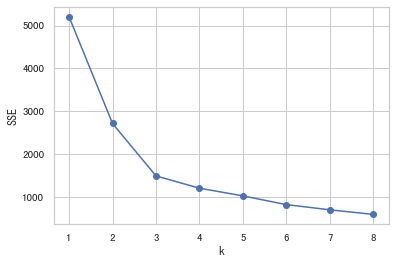

In [9]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

'利用SSE选择k'
SSE = []  # 存放每次结果的误差平方和
for k in range(1,9):
    estimator = KMeans(n_clusters=k)  # 构造聚类器
    estimator.fit(data3)
    SSE.append(estimator.inertia_) # estimator.inertia_获取聚类准则的总和
X = range(1,9)
plt.xlabel('k')
plt.ylabel('SSE')
plt.plot(X,SSE,'o-')
plt.show()

### 通过平均轮廓系数检验得到最佳KMeans聚类模型

轮廓系数：-----聚类的评估指标
            好的聚类：内密外疏，同一个聚类内部的样本要足够密集，不同聚类之间样本要足够疏远。

            轮廓系数计算规则：针对样本空间中的一个特定样本，计算它与所在聚类其它样本的平均距离a，
            以及该样本与距离最近的另一个聚类中所有样本的平均距离b，该样本的轮廓系数为(b-a)/max(a, b)，
            将整个样本空间中所有样本的轮廓系数取算数平均值，作为聚类划分的性能指标s。

            轮廓系数的区间为：[-1, 1]。 -1代表分类效果差，1代表分类效果好。0代表聚类重叠，没有很好的划分聚类。

In [10]:
score_list = []   # 储存系数的列表
score_init = -1   # 初始轮廓系数
for n_k in range(2,11):
    model_kmeans = KMeans(n_clusters=n_k,random_state=0)  # 建立模型
    cluster_tmp = model_kmeans.fit_predict(data3) # 训练模型
    score_tmp = metrics.silhouette_score(data3,cluster_tmp)  # 得到K值的轮廓系数
    if score_tmp > score_init:  # 如果这个系数更高
        good_k = n_k  #储存K值
        score_init = score_tmp  #储存轮廓系数，做下次比较
        good_model = model_kmeans  # 储存模型
        good_cluster = cluster_tmp  # 储存聚类标签
    score_list.append([n_k,score_tmp])


print('{:-^60}'.format('K value and silhouette summary:'))
print(np.array(score_list)) #打印输出k下的详细得分
print ('Best K is:{0} with average silhouette of {1}'.format(good_k, score_init.round(4)))

--------------K value and silhouette summary:---------------
[[ 2.          0.46692821]
 [ 3.          0.54904646]
 [ 4.          0.56968547]
 [ 5.          0.49697432]
 [ 6.          0.4390303 ]
 [ 7.          0.48204261]
 [ 8.          0.50913308]
 [ 9.          0.52697493]
 [10.          0.54338762]]
Best K is:4 with average silhouette of 0.5697


## 4.聚类及结果

In [11]:
good_k =4
kmodel = KMeans(n_clusters =good_k,random_state=0) 
kmodel.fit(data3) #训练模型
#kmodel.labels_

KMeans(n_clusters=4, random_state=0)

In [12]:
pd.Series(kmodel.labels_).value_counts()  #统计各个类别的数目

1    411
0    297
2    154
3     27
dtype: int64

In [13]:
kmodel.cluster_centers_  #各个类别的中心

array([[0.01823786, 0.03584007, 0.04265509, 0.01453513, 0.07498273,
        0.01661262, 0.54754441, 0.62962963, 4.03703704, 2.97643098,
        1.94276094, 0.38720539],
       [0.02131106, 0.02454247, 0.02230043, 0.0088128 , 0.0453313 ,
        0.00893557, 0.50348184, 0.88321168, 0.35036496, 2.91484185,
        1.91484185, 0.54014599],
       [0.02462089, 0.06782476, 0.01937094, 0.01207341, 0.05573705,
        0.01528448, 0.50985222, 0.97402597, 1.32467532, 0.68831169,
        0.00649351, 0.00649351],
       [0.03848938, 0.03078526, 0.04902675, 0.02932336, 0.09896783,
        0.02774784, 0.49553001, 1.03703704, 0.2962963 , 5.77777778,
        3.77777778, 0.77777778]])

In [14]:
cluster=pd.DataFrame(kmodel.labels_,columns=['cluster'])
merge_data = pd.concat((data_2,cluster),axis=1)
merge_data.head()

,渠道代号,日均UV,平均注册率,平均搜索量,访问深度,平均停留时间,订单转化率,投放总时间,素材类型,广告类型,合作方式,广告尺寸,广告卖点,cluster
0,A203,3.69,0.0071,0.0214,2.3071,419.77,0.0258,20.0,jpg,banner,roi,140*40,打折,2
1,A387,178.70,0.0040,0.0324,2.0489,157.94,0.0030,19.0,jpg,banner,cpc,140*40,满减,2
2,A388,91.77,0.0022,0.0530,1.8771,357.93,0.0026,4.0,jpg,banner,cpc,140*40,满减,2
3,A389,1.09,0.0074,0.3382,4.2426,364.07,0.0153,10.0,jpg,banner,cpc,140*40,满减,2
4,A390,3.37,0.0028,0.1740,2.1934,313.34,0.0007,30.0,jpg,banner,cpc,140*40,满减,2


## 5.寻找各个分类的数据特征

In [15]:
# 计算每个类别的计数
cluster_count = pd.DataFrame(merge_data["渠道代号"].groupby(
                merge_data['cluster']).count()).T.rename({"渠道代号":"count"})

# 计算每个类别的占比
cluster_ratio = (cluster_count / len(merge_data)).round(4).rename(
                {"count":"per"})

cluster_features = []  # 空列表，储存特征信息
for line in range(good_k):
    label_data = merge_data[merge_data["cluster"] == line]  # 获得特定类别数据
    part1_data = label_data.iloc[:,1:8] # 获得数值型数据
    part1_desc = part1_data.describe().round(3)
    merge_data_mean = part1_desc.iloc[2,:]   # 均值特征
    
    part2_data = label_data.iloc[:,8:-1]   # 获得字符串数据特征
    part2_desc = part2_data.describe(include="all")
    merge_data2_mean = part2_desc.iloc[2,:]   # 均值特征
    merge_line = pd.concat((merge_data_mean,merge_data2_mean),axis=0)  # 合并
    cluster_features.append(merge_line)  # 添加到列表中
    
cluster_df = pd.DataFrame(cluster_features).T
cluster_all = pd.concat((cluster_count,cluster_ratio,cluster_df),axis=0)
cluster_all

,0,1,2,3
count,297,411,154,27
per,0.3341,0.4623,0.1732,0.0304
日均UV,1194.69,1369.81,2718.7,1263.03
平均注册率,0.003,0.003,0.005,0.003
平均搜索量,0.144,0.082,0.051,0.151
访问深度,5.728,0.918,0.948,9.8
平均停留时间,285.992,165.094,104.14,374.689
订单转化率,0.016,0.009,0.007,0.017
投放总时间,8.57,8.462,8.569,7.996
素材类型,jpg,swf,jpg,swf


In [16]:
# 绘制极坐标图来可视化数据特征
num_sets = cluster_df.iloc[:7,:].T.astype(np.float64)   # 提取展示的数据
print(num_sets)
num_sets_minmax = minmax_scaler.fit_transform(num_sets)  # 标准化
print('-'*20,'num_sets_minmax','-'*20)
print(num_sets_minmax)

       日均UV  平均注册率  平均搜索量   访问深度   平均停留时间  订单转化率  投放总时间
0  1194.692  0.003  0.144  5.728  285.992  0.016  8.570
1  1369.808  0.003  0.082  0.918  165.094  0.009  8.462
2  2718.703  0.005  0.051  0.948  104.140  0.007  8.569
3  1263.027  0.003  0.151  9.800  374.689  0.017  7.996
-------------------- num_sets_minmax --------------------
[[0.         0.         0.93       0.5415447  0.6721592  0.9
  1.        ]
 [0.11490468 0.         0.31       0.         0.22529745 0.2
  0.81184669]
 [1.         1.         0.         0.00337762 0.         0.
  0.99825784]
 [0.04483892 0.         1.         1.         1.         1.
  0.        ]]


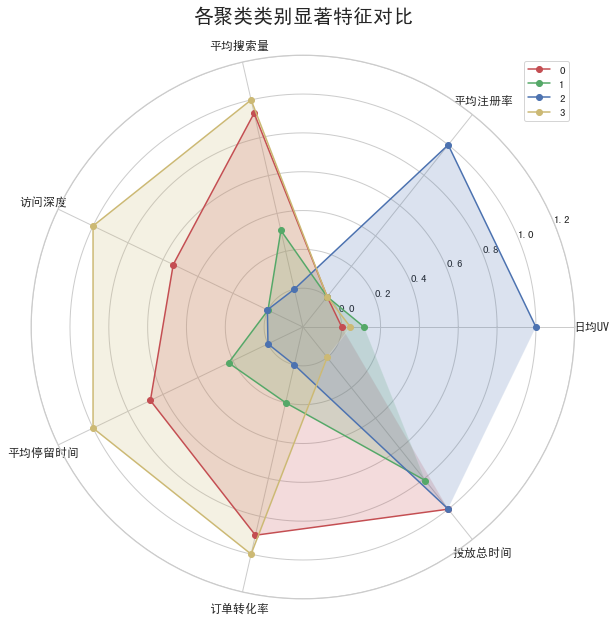

In [19]:
# 绘图

import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif']=['SimHei']#显示中文标签 
plt.rcParams['axes.unicode_minus']=False

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111,polar=True)
labels = np.array(merge_data_mean.index)   # 数据标签
colors = ['r','g','b','y']
angles = np.linspace(0,2*np.pi,len(labels),endpoint=False)   # 计算各区间角度


for i in range(len(num_sets)):
    df=  num_sets_minmax[i,:]
    ax.plot(angles,df,'o-',c=colors[i],label=i) 
    ax.fill(angles,df, facecolor=colors[i], alpha=0.2)# 填充颜色和透明度
    
ax.set_thetagrids(angles*180/np.pi,labels,fontproperties='SimHei',fontsize=12)
ax.set_title("各聚类类别显著特征对比",fontsize=20)  # 设置标题放置
ax.set_rlim(-0.2, 1.2)  # 设置坐标轴尺度范围
plt.legend(loc=0)  # 设置图例位置
plt.show()  # 展示图像


## 6.数据结论分析

- 初步分析

从结果看，所有的渠道被分为4个类别，每个类别的样本量分别为297、411、154、27，对应的占比分别33%、46%、17%、3%。第四个类别样本量最少。

结合雷达图，可以清晰地看到不同类别广告媒体的特征倾向：

聚类0：这类广告媒体在访问深度、平均停留时间、订单转化率集平均搜索量等流量质量的特征上表现较好，除了注册转换率较低外，该类渠道各方面比较均衡。更重要的是该类媒体的数量占据了33%，因此是一类规模较大且综合效果较好的媒体。  
聚类1：各方面的特征都不明显，换句话说就是效果比较平庸，没有明显的优势或短板。但这些“中庸”的广告媒体却构成了整个广告的主体。  
聚类2：这类渠道跟其他几类渠道有个明显的特征区隔，其日均uv和平均注册率非常突出，证明这是一类“引流”+“拉新”的渠道；而其他的流量质量方面表现却比较差。  
聚类3：这类广告媒体跟聚类1非常类似，并且相对聚类2的典型特征表现更好，但综合其只占3%的媒体数量，属于少量的“精英“类渠道。 

- 深入分析

聚类0：这类广告渠道的短板是日均uv和平均注册率，因此该类媒体无法为企业带来大量的流量以及新用户。这类广告的特质适合用户转化，尤其是有关订单转化的提升。  
聚类1：该广告渠道各方面表现均比较一般，因此需要业务部门重点考虑其投放的实际价值。      
聚类2：这类渠道更符合广告本身“广而告之“的基础诉求，因此适合在大规模广告宣传和引流时使用，尤其对于新用户的注册转化上的效果非常明显，也适合“拉新”使用。  
聚类3：这类广告渠道跟聚类1的特征非常类似，也适合做订单转换的提升，并且由于其实际效果更好，因此效果会更加明显。 

## 7.案例应用和部署

对于以上四类广告媒体，需要针对其不同的特征做针对性的运营应用：

对于聚类1的广告媒体，在资金不足或优化广告结构时，重点考虑其取舍问题；

对于聚类0和聚类3的广告媒体，优化应用的方向有两个：

一是增加对于注册转化效果的优化效应，重点从人群匹配、注册引导、注册激励等方面加强运营。在该过程中，打折、直降等优惠宣传点可以重点突出，广告素材本身以较大中等广告为主，例如900x120.  
二是对于整体广告效果的支撑价值。考虑到其流量规模的局限性，这类渠道更加适合在广告结构中作为一类具有流量质量支撑价值的角色，可以用来提升全局广告的订单质量效果，因此是一类非常关键的质量渠道。尤其是聚类2的广告媒体其质量指标表现非常优异，应该优先考虑投放组合。  

对于聚类2的广告媒体，其可以作为在每次大型促销活动时引流的骨干，因为这更符合本身在全部推给媒体中的角色定位。对于这类媒体的单位流量成本需要重点关注，实际投放过程中可以满减为促销点、通过较大尺寸（如308*338）的广告类型做引导流量点击。

In [101]:
mac中文字体解决：
import matplotlib    
print(matplotlib.matplotlib_fname())

/Users/lizhang/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/matplotlibrc


mac中文字体解决：
https://blog.csdn.net/weixin_38037405/article/details/107127610